In [1]:
import sys
sys.path.insert(0, '../')
from util import util
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats.mstats import gmean
import seaborn as sns
import pandas as pd

Text(0.5,1,'Possible beta distributions')

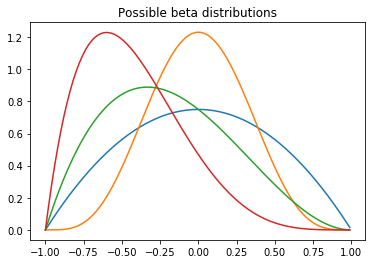

In [2]:
# plot the pdf within the range
x = np.arange (-1, 1, 0.01)

Y1 = st.beta(a = 2,b=2,loc=-1,scale=2)
z = Y1.pdf(x)
plt.plot(x,z)

Y2 = st.beta(a = 5,b=5,loc=-1,scale=2)
z = Y2.pdf(x)
plt.plot(x,z)

Y3 = st.beta(a = 2,b=3,loc=-1,scale=2)
z = Y3.pdf(x)
plt.plot(x,z)

Y4 = st.beta(a = 2,b=5,loc=-1,scale=2)
z = Y4.pdf(x)
plt.plot(x,z)
plt.title("Possible beta distributions")

In [3]:
def fit_beta(Y,n_samples,x_values,fit_type,support=(None,None),plot_observed=False,**kwargs):
    #fig, axs = plt.subplots(4,5, figsize=(15, 15), facecolor='w', edgecolor='k')
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    fig, axs = plt.subplots(2,5, figsize=(12, 8), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i in range(10):
        S = Y.rvs(n_samples)
        for ele in fit_type:
            if ele.lower() == 'mle':
                beta_params = st.beta.fit(S)
                a,b,loc,scale = minimize(beta_loglikelihood,beta_params,args=(S),
                                    bounds=((1,None),(1,None),(support[0],support[0]),
                                           (support[1],support[1]))).x
                #a,b,loc,scale = st.beta.fit(S)
                fitted_beta = st.beta(a=a,b=b,loc=loc,scale=scale)

                #plt.hist(S,normed=True)

                y_values = fitted_beta.pdf(x_values)
            elif ele.lower() == 'kde':
                # fit a kde, optimising bandwidth
                fitted = st.gaussian_kde(S,bw_method='scott')
                y_values = fitted.pdf(x_values)
            elif ele.lower() == 'mse':
                params = st.beta.fit(S,**kwargs)
                a1,b1,loc1,scale1 = minimize(maximum_spacing,params,args=(S)).x
                fitted_beta = st.beta(a=a1,b=b1,loc=loc1,scale=scale1)
                y_values = fitted_beta.pdf(x_values)
            elif ele.lower() == 'ks':
                params = st.beta.fit(S)
                a,b,loc,scale = minimize(test_compute_kstest,params,args=(S),
                                    bounds=((1,None),(1,None),(support[0],support[0]),
                                           (support[1],support[1]))).x
                fitted_beta = st.beta(a=a,b=b,loc=loc,scale=scale)
                y_values = fitted_beta.pdf(x_values)
            else:
                raise ValueError("Not a valid estimation method")
            
            axs[i].plot(x_values, y_values,label=ele)
            
        if plot_observed:
            axs[i].hist(S,normed=True,label='Observed samples')
        axs[i].plot(x_values, Y.pdf(x_values),label='True pdf')
        axs[i].yaxis.set_visible(False)
    axs[i].legend()

In [4]:
def sampleSpacings(x):
    #calculates the sample spacings of X
    D=[xi-x[i] for i,xi in enumerate(x[1:])]
    return np.array(D)

def maximum_spacing(parameters,samples):
    # sort the samples
    orderedSample=np.sort(samples)
    
    # obtain the cdf of samples
    sample_cdf = st.beta.cdf(orderedSample,parameters[0],
                          parameters[1],parameters[2],parameters[3])
    # get the spacings
    spacings = sampleSpacings(sample_cdf)
    
    # we maximise (min) the (negative) log of geometric mean of spacing
    return -np.log(gmean(spacings))

In [5]:
from scipy.stats import kstest
def compute_kstest(parameters,samples):
    test = kstest(samples,'beta',args=parameters)
    return test[0]

def ecdf(x):
    # normalize X to sum to 1
    #x = x / np.sum(x)
    ys = np.arange(1, len(x)+1)/float(len(x))
    return ys

# my own implementation of the ks test statistic
# we sort the samples, 
# compute the cdf of those samples for a given beta
# compute  the empirical cdf
# take the maximum of the absolute difference of beta cdf and empirical cdf
def test_compute_kstest(parameters,samples,support=(None,None)):
    samples = np.sort(samples)
    if support[0] is not None:
        beta_cdf = st.beta.cdf(samples, parameters[0], parameters[1], 
                       loc=support[0], scale=support[1])
    else:
        beta_cdf = st.beta.cdf(samples, parameters[0], parameters[1], 
                       loc=parameters[2], scale=parameters[3])
    ecdf_result = ecdf(samples)
    ks_test = np.max(np.abs(ecdf_result-beta_cdf))
    #test = kstest(samples,'beta',args=parameters)
    return ks_test

In [6]:
def beta_loglikelihood(params,samples):
    log_pdf = st.beta.logpdf(samples, params[0], params[1], loc=params[2], scale=params[3])
    return -np.sum(log_pdf)

/usr/local/lib/python2.7/dist-packages/scipy/optimize/optimize.py:643: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/harrison/.local/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


Text(0.5,1,'MLE and KS with fixed support')

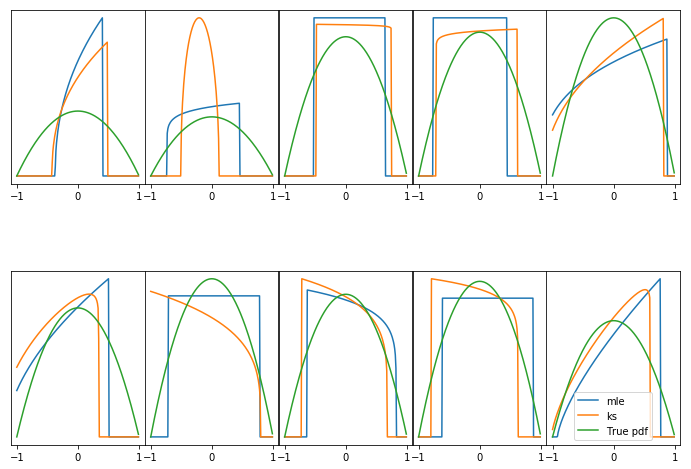

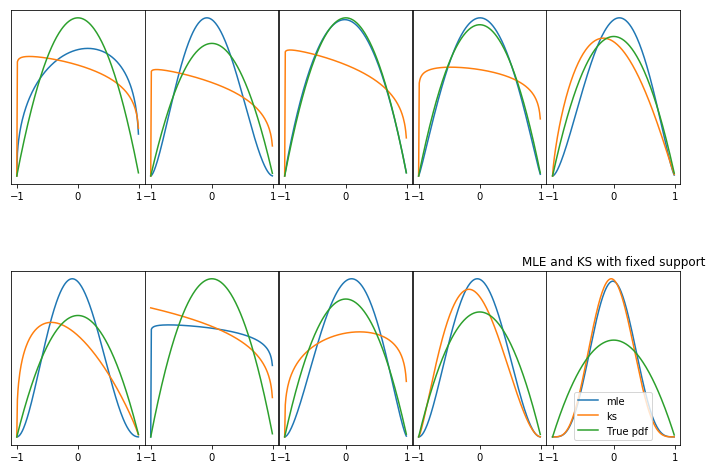

In [7]:
fit_beta(Y1,10,x,['mle','ks'])

fit_beta(Y1,10,x,['mle','ks'],support=(-1,2))
plt.title("MLE and KS with fixed support")

In [8]:
# simple quadratic cost function
# f1 = lambda x,y: -x*y + 0.2*x**2 
f1 = lambda x,y: -x*y + 5*x**2 + 2*x 

f3 = lambda x,y: 3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y

f2 = lambda x,y: -x*y + 0.2*x**2

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [10]:
def minimise_dist(distribution,function,n_samples=10000):
    # minimises a cost function according to a given distribution
    samples = distribution.rvs(size=n_samples)
    
    # minimise the cost function
    res = minimize(function,0.0,args=(samples))
    return res.x

In [11]:
# concave function in x
f1_mean = lambda x,y: np.mean(f1(x,y),axis=0)
f2_mean = lambda x,y: np.mean(f2(x,y),axis=0)
f3_mean = lambda x,y: np.mean(f3(x,y),axis=0)

In [12]:
def mle(S,function,beta_params,initial_xstar,n_samples,support=(None,None)):
    
    if support[0] is not None:
        a,b,loc,scale = st.beta.fit(S,floc=support[0],fscale=support[1])
    else:
        a,b,loc,scale = minimize(beta_loglikelihood,beta_params,args=(S),
                                bounds=((1,None),(1,None),(None,None),
                                       (0,None)),options={'maxiter':1000}).x
    fitted_beta = st.beta(a=a,b=b,loc=loc,scale=scale)
    samples = fitted_beta.rvs(size=n_samples)
    res = minimize(function,initial_xstar,args=(samples))

    return res.x[0]

In [13]:
def kde(S,function,initial_xstar,n_samples):
 # fit distribution using kde
    fitted = st.gaussian_kde(S,bw_method='scott')
    samples = fitted.resample(size=n_samples)
    res = minimize(function,initial_xstar,args=(np.reshape(samples,(-1))))
    return res.x[0]

In [14]:
def mse(S,function,beta_params,initial_xstar,n_samples,support=(None,None)):
    # fit distribution using maximum spacing estimation
    a,b,loc,scale = minimize(maximum_spacing,beta_params,args=(S),
                                bounds=((1,None),(1,None),(support[0],support[0]),
                                       (support[1],support[1]))).x
    fitted_beta = st.beta(a=a,b=b,loc=loc,scale=scale)
    samples = fitted_beta.rvs(size=n_samples)
    res = minimize(function,initial_xstar,args=(samples))
    return res.x[0]

In [15]:
def ks(S,function,beta_params,initial_xstar,n_samples,support=(None,None)):
    
    if support[0] is not None:
        a,b = minimize(test_compute_kstest,beta_params[:2],args=(S,support),
                                bounds=((1,None),(1,None)),options={'maxiter':1000}).x
        loc = support[0]
        scale = support[1]
    else:
        a,b,loc,scale = minimize(test_compute_kstest,beta_params,args=(S),
                                bounds=((1,None),(1,None),(None,None),
                                   (0,None)),options={'maxiter':1000}).x
    fitted_beta = st.beta(a=a,b=b,loc=loc,scale=scale)
    
    samples = fitted_beta.rvs(size=n_samples)
    res = minimize(function,initial_xstar,args=(samples))
    return res.x[0]

In [16]:
def minimise_methods(distribution,function,method,N,n_iter=500,n_samples=5000):
    #results = np.zeros((len(method),n_iter,len(N)))
    results = pd.DataFrame(columns=['x_star','method','N','distribution'])
    #total = n_iter*len(distribution)*len(N)
    for j, dist in enumerate(distribution):
        many_samples = dist.rvs(n_samples)
        true_sol = minimize(function,0.0,args=(many_samples)).x[0]
        for m in range(len(N)):
            temp = {}
            temp['x_star']  = true_sol
            temp['N'] = N[m]
            temp['distribution'] = j
            temp['method'] = 'true'
            results = results.append(temp,ignore_index=True)
        for i in range(n_iter):
            for k in range(len(N)):
                temp = {}
                temp['distribution'] = j
                temp['N'] = N[k]
                # obtain the samples
                S = dist.rvs(N[k])
                beta_params = st.beta.fit(S)
                for l, ele in enumerate(method):
                    if ele == 'saa':
                        # maximise using SAA
                        SAA_xstar = minimize(function,0.0,args=(S)).x[0]
                        temp['x_star'] = SAA_xstar
                    elif ele == 'mle':
                        temp['x_star'] = mle(S,function,beta_params,SAA_xstar,n_samples)
                    elif ele == 'kde':
                        temp['x_star'] = kde(S,function,SAA_xstar,n_samples)
                    elif ele == 'mse':
                        temp['x_star'] = mse(S,function,beta_params,SAA_xstar,n_samples)
                    elif ele == 'mle_fixed':
                        temp['x_star'] = mle(S,function,beta_params,
                                               SAA_xstar,n_samples,support=(-1,2))
                    elif ele == 'ks':
                        temp['x_star'] = ks(S,function,beta_params,SAA_xstar,n_samples)
                    elif ele == 'ks_fixed':
                        temp['x_star'] = ks(S,function,beta_params,SAA_xstar,
                                            n_samples,support=(-1,2))
                    else:
                        raise ValueError("Not a vlid method")
                    temp['method'] = ele
                    results = results.append(temp,ignore_index=True)
    return results

In [17]:
def plot_result(results,x_labels,plot_histogram=False,y_label='average expected cost'):
    #plt.figure(figsize=(10,5))
    if plot_histogram:
        for i in range(results.shape[0]):
            plt.hist(results[i,:,0],bins=30,normed=True,alpha=1.0/(i+1))
            plt.title("Distribution of x_star for N=25")
    else:
        mean=np.mean(results,axis=1)
        std=np.std(results,axis=1)
        width=0.05
        N = [10,25,50]
        #for i in range(results.shape[0]):
        for i in range(results.shape[-1]):
            plt.figure(figsize=(10,5))
        #sns.boxplot(x="no of samples", y="expected cost", hue="technique",
        #            data=results, palette="Set3")
            #for j in range(results.shape[0]):
            plt.boxplot(results[:,:,i].T)
            #plt.bar(np.arange(len(N))+width*i, mean[i]-min(mean[i]), 
            #        width,bottom=min(mean[i]),
            #       yerr=std[i])
            #plt.xticks(np.arange(len(N)) + width / 2, (N))
            #
            plt.xticks(np.arange(6)+1 + width / 2,
                       x_labels)
            plt.ylabel('Expected cost')
            plt.title("Expected cost for %s" %str(N[i]))
            plt.show()
            #plt.plot(N,mean[i])
            #plt.errorbar(N, mean[i], yerr=std[i],capsize=5)
        #plt.xlabel('No of samples')
        #
        #plt.legend(['SAA','MLE','KDE','MSE','fixed support MSE','KS'])

In [18]:
N = [10,25,50]
n_iter = 1000
n_samples = 5000
methods = ['saa','mle','ks','mle_fixed','ks_fixed']
distributions = [Y1,Y2,Y3,Y4]

## Results 2.1
These are the results for: <br>
            <center>$ 5x^2 -xy + 2x $</center>

Text(0.5,0,'y')

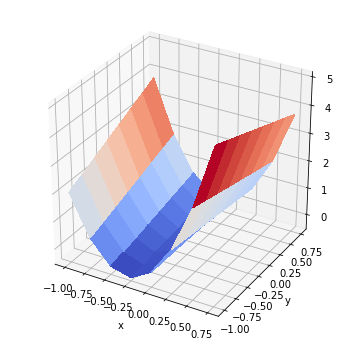

In [19]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f1(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [20]:
results1 = minimise_methods(distributions,f1_mean,methods,N,n_iter,n_samples)

/usr/local/lib/python2.7/dist-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  w

In [21]:
def calculate_expected_cost(x_star_array,distribution,function,n_samples=10000):
    """
    we calculate the expected cost for a given x*, cost function and
    beta distribution using monte carlo
    """
    samples = distribution.rvs(n_samples)
    expected_cost = np.mean(function(np.reshape(x_star_array,(-1,1)),samples),axis=1)
    return np.reshape(expected_cost,x_star_array.shape)

In [22]:
def calculate_expected_cost_pandas(df,distributions,function,n_samples=10000):

    for i, ele in enumerate(distributions):
        mask = df['distribution']==i
        samples = ele.rvs(n_samples)
        func = lambda x: np.mean(function(x,samples))
        df.loc[mask,'expected_cost'] = df.loc[mask,'x_star'].apply(func)
    return df

In [23]:
results1 = calculate_expected_cost_pandas(results1,
                                    distributions,f1)

In [24]:
results1.groupby(["distribution","N","method"]).mean()

x_star  expected_cost
distribution N  method                            
0            10 ks        -0.207970      -0.198762
                ks_fixed  -0.207801      -0.198078
                mle       -0.201223      -0.198968
                mle_fixed -0.200679      -0.199231
                saa       -0.200693      -0.199221
                true      -0.201166      -0.200116
             25 ks        -0.202933      -0.199642
                ks_fixed  -0.203090      -0.198786
                mle       -0.199914      -0.199692
                mle_fixed -0.200012      -0.199727
                saa       -0.199948      -0.199720
                true      -0.201166      -0.200116
             50 ks        -0.201572      -0.199901
                ks_fixed  -0.201333      -0.199663
                mle       -0.200056      -0.199934
                mle_fixed -0.200060      -0.199926
                saa       -0.200020      -0.199926
                true      -0.201166      -0.200116
1            10 ks        -0.205551      -0.199005
                ks_fixed  -0.206106      -0.197264
                mle       -0.200754      -0.199003
                mle_fixed -0.200740      -0.199241
                saa       -0.200744      -0.199239
                true      -0.199853      -0.199706
             25 ks        -0.201943      -0.199339
                ks_fixed  -0.201473      -0.194468
                mle       -0.199847      -0.199303
                mle_fixed -0.199862      -0.199526
                saa       -0.199855      -0.199528
                true      -0.199853      -0.199706
...                             ...            ...
2            25 ks        -0.222506      -0.241002
                ks_fixed  -0.223642      -0.239635
                mle       -0.216792      -0.240931
                mle_fixed -0.219741      -0.241065
                saa       -0.219752      -0.241058
                true      -0.220093      -0.241373
             50 ks        -0.221810      -0.241167
                ks_fixed  -0.222061      -0.240787
                mle       -0.219166      -0.241179
                mle_fixed -0.220457      -0.241201
                saa       -0.220444      -0.241199
                true      -0.220093      -0.241373
3            10 ks        -0.248233      -0.294505
                ks_fixed  -0.247380      -0.293894
                mle       -0.237360      -0.293900
                mle_fixed -0.242850      -0.294653
                saa       -0.242789      -0.294650
                true      -0.242742      -0.295173
             25 ks        -0.244813      -0.294803
                ks_fixed  -0.247039      -0.293897
                mle       -0.238135      -0.294526
                mle_fixed -0.243157      -0.294968
                saa       -0.243134      -0.294968
                true      -0.242742      -0.295173
             50 ks        -0.243932      -0.294943
                ks_fixed  -0.246025      -0.294350
                mle       -0.241059      -0.294885
                mle_fixed -0.243139      -0.295075
                saa       -0.243153      -0.295075
                true      -0.242742      -0.295173

[72 rows x 2 columns]

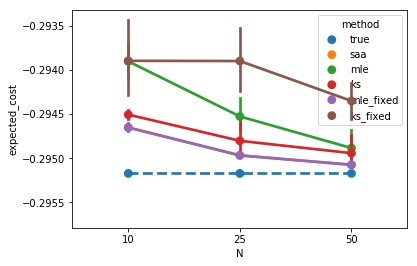

In [25]:
fig, ax = plt.subplots()
sns.pointplot(x="N", y="expected_cost", hue="method",
                data=results1[results1['distribution']==3],
             ax=ax,linestyles=['--']+['-']*5)

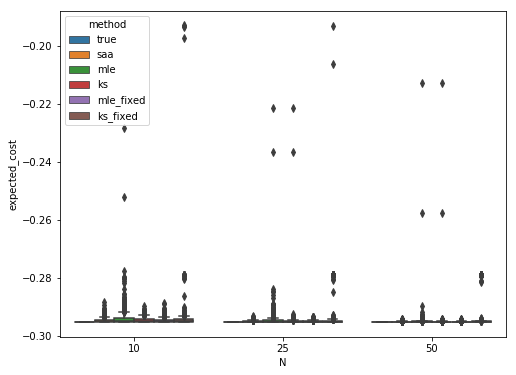

In [26]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="N", y="expected_cost", hue="method",
                data=results1[results1['distribution']==3])

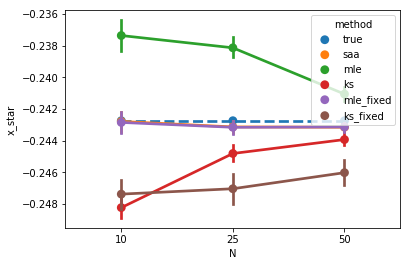

In [27]:
fig, ax = plt.subplots()
sns.pointplot(x="N", y="x_star", hue="method",
                data=results1[results1['distribution']==3],
             ax=ax,linestyles=['--']+['-']*5)

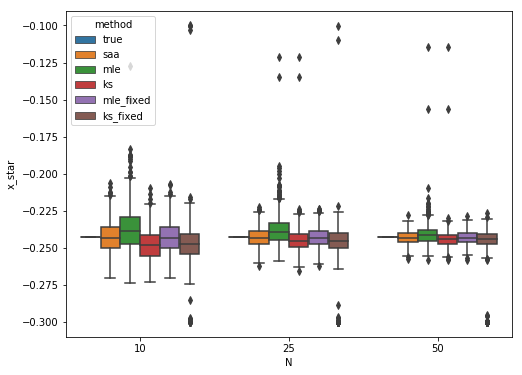

In [28]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="N", y="x_star", hue="method",
                data=results1[results1['distribution']==3])

In [29]:
def plot_distribution_results(results,labels):
    width = 0.1  
    # no of distributions
    no_distribution = len(results)
    ind = np.arange(no_distribution)
    
    mean = np.mean(
        np.array([expected_cost1,expected_cost2,expected_cost3,expected_cost4]),axis=2)
    std = np.std(
        np.array([expected_cost1,expected_cost2,expected_cost3,expected_cost4]),axis=2)
    for i in range(std.shape[-1]):
        for j in range(std.shape[1]):
            plt.bar(ind+width*j, mean[:,j,i]+0.20, width,bottom=-0.20, label=labels[j],
                   yerr=std[:,j,i])
        plt.xticks(ind + width / 2, ('Y1', 'Y2', 'Y3', 'Y4'))
        plt.legend()
        plt.show()


## Results 2.2
These are the results for: <br>
            <center>$0.2x^2 -xy $</center>

Text(0.5,0,'y')

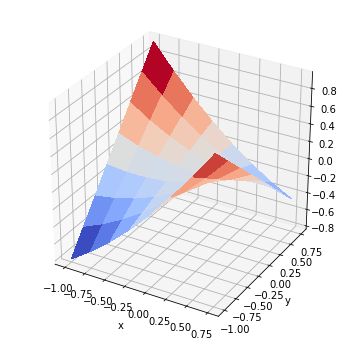

In [30]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f2(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [31]:
results2 = minimise_methods(distributions,f2_mean,methods,N,n_iter,n_samples)
results2 = calculate_expected_cost_pandas(results2,
                                    distributions,f2)

/usr/local/lib/python2.7/dist-packages/scipy/optimize/optimize.py:543: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


In [32]:
results2.groupby(["distribution","N","method"]).mean()

x_star  expected_cost
distribution N  method                            
0            10 ks        -0.187936       0.035664
                ks_fixed  -0.188254       0.050300
                mle       -0.019739       0.026995
                mle_fixed -0.012745       0.025114
                saa       -0.013306       0.025518
                true       0.007324       0.000017
             25 ks        -0.082750       0.013073
                ks_fixed  -0.080104       0.033390
                mle       -0.005663       0.011211
                mle_fixed -0.007396       0.010343
                saa       -0.008052       0.010657
                true       0.007324       0.000017
             50 ks        -0.040548       0.005884
                ks_fixed  -0.040566       0.006991
                mle        0.004457       0.004801
                mle_fixed -0.001455       0.004986
                saa       -0.000681       0.005082
                true       0.007324       0.000017
1            10 ks        -0.111454       0.015876
                ks_fixed  -0.127617       0.064854
                mle        0.000843       0.018048
                mle_fixed  0.004548       0.011938
                saa        0.004824       0.012053
                true       0.015665       0.000078
             25 ks        -0.051404       0.005021
                ks_fixed  -0.052131       0.151617
                mle        0.003416       0.005677
                mle_fixed -0.002846       0.004334
                saa       -0.002465       0.004328
                true       0.015665       0.000078
...                             ...            ...
2            25 ks        -0.568570      -0.042212
                ks_fixed  -0.604541      -0.011785
                mle       -0.421980      -0.038928
                mle_fixed -0.500636      -0.043275
                saa       -0.500068      -0.043241
                true      -0.484488      -0.051346
             50 ks        -0.539202      -0.046975
                ks_fixed  -0.543581      -0.037392
                mle       -0.470863      -0.046399
                mle_fixed -0.503625      -0.047442
                saa       -0.503221      -0.047466
                true      -0.484488      -0.051346
3            10 ks        -1.203220      -0.217754
                ks_fixed  -1.173421      -0.205374
                mle       -0.912637      -0.202371
                mle_fixed -1.068183      -0.221078
                saa       -1.066466      -0.221051
                true      -1.062928      -0.233756
             25 ks        -1.112389      -0.224612
                ks_fixed  -1.163974      -0.205541
                mle       -0.948756      -0.216331
                mle_fixed -1.068762      -0.228845
                saa       -1.068313      -0.228826
                true      -1.062928      -0.233756
             50 ks        -1.089299      -0.228242
                ks_fixed  -1.158624      -0.209225
                mle       -1.020155      -0.225893
                mle_fixed -1.070198      -0.231382
                saa       -1.070640      -0.231385
                true      -1.062928      -0.233756

[72 rows x 2 columns]

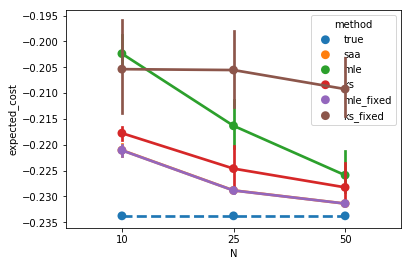

In [33]:
fig, ax = plt.subplots()
sns.pointplot(x="N", y="expected_cost", hue="method",
                data=results2[results2['distribution']==3],
             ax=ax,linestyles=['--']+['-']*5)

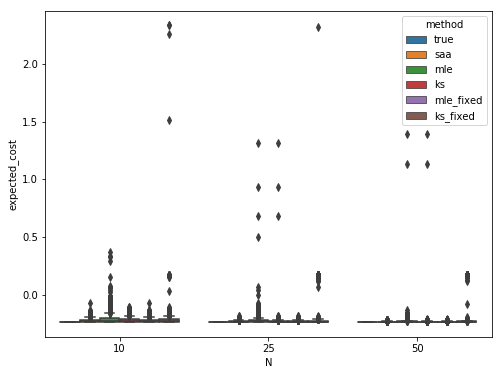

In [34]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="N", y="expected_cost", hue="method",
                data=results2[results2['distribution']==3])

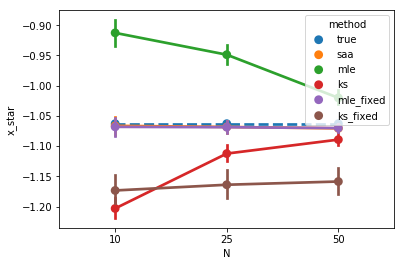

In [35]:
fig, ax = plt.subplots()
sns.pointplot(x="N", y="x_star", hue="method",
                data=results2[results2['distribution']==3],
             ax=ax,linestyles=['--']+['-']*5)

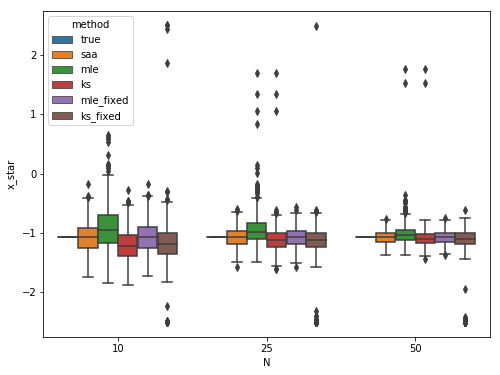

In [36]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="N", y="x_star", hue="method",
                data=results2[results2['distribution']==3])

## Results
These are the results for: <br>
            <center>$ 3x^2 + 6xy^2 - 2x^2y - 7xy $</center>

Text(0.5,0,'y')

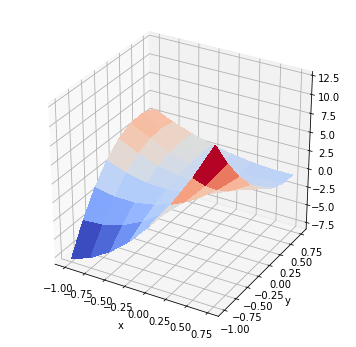

In [37]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f3(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [38]:
results3 = minimise_methods(distributions,f3_mean,methods,N,n_iter,n_samples)
results3 = calculate_expected_cost_pandas(results3,
                                    distributions,f3)

In [39]:
results3.groupby(["distribution","N","method"]).mean()

x_star  expected_cost
distribution N  method                            
0            10 ks        -0.251561      -0.002527
                ks_fixed  -0.288453       0.033479
                mle       -0.195699       0.110727
                mle_fixed -0.180831      -0.033347
                saa       -0.187194      -0.030606
                true      -0.183214      -0.108931
             25 ks        -0.229736      -0.065492
                ks_fixed  -0.259230      -0.014646
                mle       -0.209362      -0.074093
                mle_fixed -0.195608      -0.076070
                saa       -0.199701      -0.075039
                true      -0.183214      -0.108931
             50 ks        -0.210240      -0.089736
                ks_fixed  -0.226609      -0.078965
                mle       -0.208218      -0.092500
                mle_fixed -0.193722      -0.094361
                saa       -0.195226      -0.093467
                true      -0.183214      -0.108931
1            10 ks        -0.134833       0.024978
                ks_fixed  -0.214792       0.175896
                mle       -0.094137       0.035580
                mle_fixed -0.085118       0.012241
                saa       -0.086887       0.012385
                true      -0.092428      -0.025805
             25 ks        -0.107673      -0.008694
                ks_fixed  -0.160659       0.227951
                mle       -0.093130      -0.006708
                mle_fixed -0.084629      -0.011163
                saa       -0.085650      -0.011260
                true      -0.092428      -0.025805
...                             ...            ...
2            25 ks        -0.417870      -0.469891
                ks_fixed  -0.459812      -0.348369
                mle       -0.362323      -0.475837
                mle_fixed -0.383872      -0.478674
                saa       -0.386342      -0.477587
                true      -0.382449      -0.508273
             50 ks        -0.396945      -0.491644
                ks_fixed  -0.418290      -0.440582
                mle       -0.376075      -0.494120
                mle_fixed -0.379966      -0.494212
                saa       -0.380873      -0.493894
                true      -0.382449      -0.508273
3            10 ks        -0.668862      -1.352182
                ks_fixed  -0.674344      -1.312915
                mle       -0.545571      -1.325438
                mle_fixed -0.606068      -1.373242
                saa       -0.606461      -1.372902
                true      -0.618451      -1.428597
             25 ks        -0.635589      -1.403422
                ks_fixed  -0.669716      -1.306633
                mle       -0.570252      -1.389395
                mle_fixed -0.609274      -1.408446
                saa       -0.609617      -1.407724
                true      -0.618451      -1.428597
             50 ks        -0.621661      -1.411332
                ks_fixed  -0.659680      -1.321251
                mle       -0.595199      -1.408011
                mle_fixed -0.610485      -1.418518
                saa       -0.610518      -1.418570
                true      -0.618451      -1.428597

[72 rows x 2 columns]

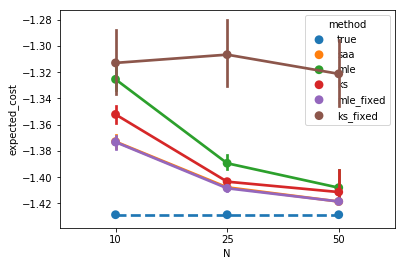

In [40]:
fig, ax = plt.subplots()
sns.pointplot(x="N", y="expected_cost", hue="method",
                data=results3[results3['distribution']==3],
             ax=ax,linestyles=['--']+['-']*5)

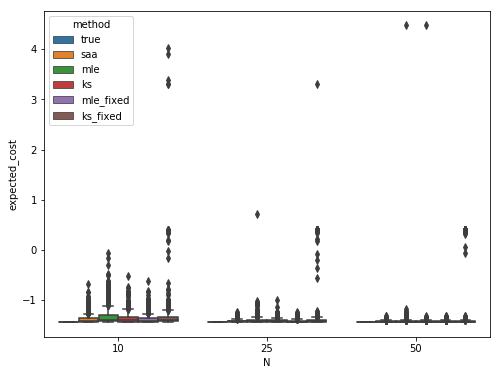

In [41]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="N", y="expected_cost", hue="method",
                data=results3[results3['distribution']==3])

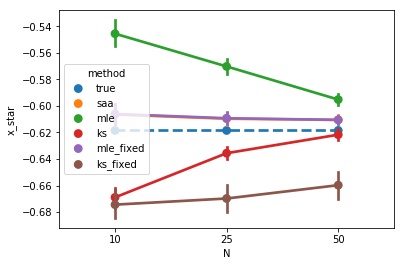

In [42]:
fig, ax = plt.subplots()
sns.pointplot(x="N", y="x_star", hue="method",
                data=results3[results3['distribution']==3],
             ax=ax,linestyles=['--']+['-']*5)

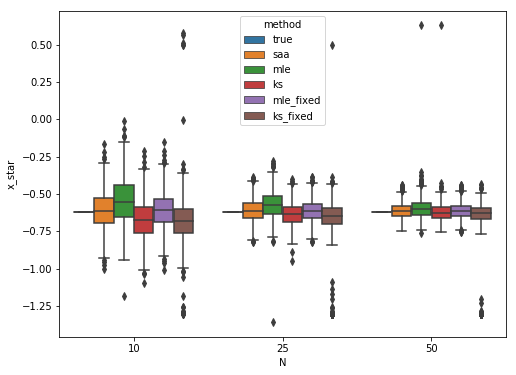

In [43]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="N", y="x_star", hue="method",
                data=results3[results3['distribution']==3])

In [44]:
results1.to_csv("results1.csv")
results2.to_csv("results2.csv")
results3.to_csv("results3.csv")